In [12]:
#import xlrd
import math
import numpy
import numpy as np
import pandas as pd

from datetime import datetime
from dateutil.relativedelta import relativedelta
import scipy
import scipy.stats as si
import matplotlib.pyplot as plt
import warnings

## Data 

In [ ]:
# sp500_path = '.\Resources\Stock and Index Options\SP500 Option.csv'
sp500_path = '/Users/cahalmurphy/Documents/UCD Files/Stage 4/Semester_2/FIN30190 - Financial Economics II/Project_B/Resources/Stock and Index Options/SP500 Option.csv'
headers = ['Date', 'SecurityID', 'SecurityPrice', 'TotalReturn', 'AdjustmentFactor', 'AdjustmentFactor2',
          'InterestRate','Expiration','Strike','OptionID', 'CallPut', 'BestBid', 'BestOffer', 'ImpliedVolatility',
          'Delta', 'Gamma', 'Vega', 'Theta']
dtypes = {'Date': str,
         'SecurityID': int,
         'SecurityPrice': np.float32,
         'TotalReturn': np.float32,
         'AdjustmentFactor': int,
         'AdjustmentFactor2': np.float32,
         'InterestRate': np.float32,
         'Expiration': str,
         'Strike': np.float32,
         'OptionID': int,
         'CallPut': str,
         'BestBid': np.float32,
         'BestOffer': np.float32,
         'ImpliedVolatility': np.float32,
         'Delta': np.float32,
         'Gamma': np.float32,
         'Vega': np.float32,
         'Theta': np.float32,
         }
def _dateparser(x):
    return datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

In [24]:
def SABR(alpha,beta,rho,nu,F,K,time): # all variables are scalars

    if K <= 0:   # negative rates' problem, need to shift the smile
        VOL = 0
        diff = 0
    elif F == K: # ATM formula
        V = (F*K)**((1-beta)/2.)
        logFK = math.log(F/K)
        A = 1 + ( ((1-beta)**2*alpha**2)/(24.*(V**2)) + (alpha*beta*nu*rho)/(4.*V) + ((nu**2)*(2-3*(rho**2))/24.) ) * time
        B = 1 + (1/24.)*(((1-beta)*logFK)**2) + (1/1920.)*(((1-beta)*logFK)**4)
        VOL = (alpha/V)*A
        
    elif F != K: # not-ATM formula
        V = (F*K)**((1-beta)/2.)
        logFK = math.log(F/K)
        z = (nu/alpha)*V*logFK
        x = math.log( ( math.sqrt(1-2*rho*z+z**2) + z - rho ) / (1-rho) )
        A = 1 + ( ((1-beta)**2*alpha**2)/(24.*(V**2)) + (alpha*beta*nu*rho)/(4.*V) + ((nu**2)*(2-3*(rho**2))/24.) ) * time
        B = 1 + (1/24.)*(((1-beta)*logFK)**2) + (1/1920.)*(((1-beta)*logFK)**4)
        VOL = (nu*logFK*A)/(x*B)
        

    return VOL


def rmse(market, model)->np.float64:
    return np.sqrt( (np.power(market-model, 2) ).mean() )


def objective_func(params, Beta, strikes, mkt_vols, fwd, tenor)->np.float64:
    model_output = []
    for strike in strikes:
        model_ivol = SABR(alpha=params[0], rho=params[1], nu=params[2], F=fwd, K=strike, time=tenor, beta=Beta)
        model_output.append(model_ivol)
        
    model_output = np.array(model_output, dtype=np.float64)
    # calculate the error
    error = rmse(market=mkt_vols, model=model_output)
    # print(x, error)
    return error

* Testing to Match MatLab

In [35]:
MarketStrikes = [2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
MarketVolatilities = [45.6, 41.6, 37.9, 36.6, 37.8, 39.2, 40.0]
dff = pd.DataFrame(index= MarketStrikes, columns=["Strike", "IV"], data={'Strike':MarketStrikes, 'IV':MarketVolatilities} )
dff/=100
dff.index/=100

In [36]:
initial_guess = [0.1, 0.2, 0.05]
bnds = ((0.01, None), (0.01, None), (-1, 1))
fwd = dff.Strike.iloc[3]
r = scipy.optimize.minimize(objective_func, x0=initial_guess,
                        args=(0.5, dff.Strike.to_numpy(), dff.IV.to_numpy(), fwd, 3), bounds=bnds)

In [37]:
r.x

array([0.06028355, 0.20970089, 0.75095967])

In [38]:
for K in dff.Strike.values:
    dff.loc[K, "sabr"] = SABR(alpha=r.x[0], rho=r.x[1], nu=r.x[2], F=fwd, K=K, time=3, beta=0.5)

In [39]:
dff

,Strike,IV,sabr
0.020,0.020,0.456,0.459735
0.025,0.025,0.416,0.408475
0.030,0.030,0.379,0.380304
0.035,0.035,0.366,0.371839
0.040,0.040,0.378,0.376629
0.045,0.045,0.392,0.388021
0.050,0.050,0.400,0.401855


<Axes: xlabel='IV', ylabel='sabr'>

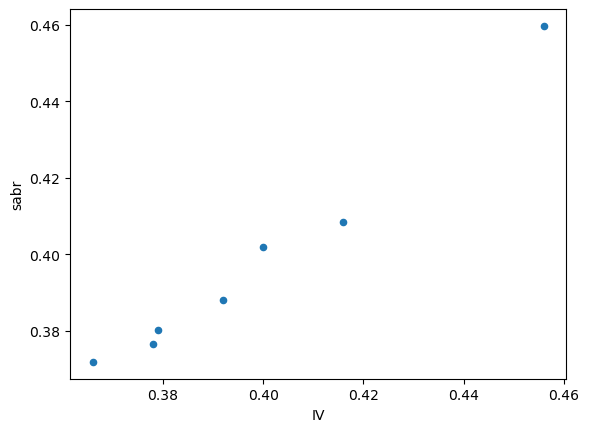

In [44]:
dff[["IV", "sabr"]].plot(kind='scatter', x='IV', y='sabr')